# Deep learning approach - CNN with chainer

We train CNN (Convolutional Neural Network), which is widely used in image recognition.

Also, I will explain several technics such as "data augmentation" and "model ensemble" 
to further improve the score.

I achieved the score "99.700" in below code.

chainer is deep learning framework written in python.
It supports dynamic graph construction (define-by-run).
Chainer is used in research field as well, since it is quite flexible library.

 - https://github.com/chainer/chainer
 
 
## Other reference for beginners

If you are not familiar with deep learning/any deep learning framework, you might want to see more simple quick start kernel at first.
Below kernel shows much more easy way to apply deep learning training, with sklearn interface.

 - https://www.kaggle.com/corochann/simple-deep-learning-with-chainer-by-sklearn-if
 
If you want to learn about chainer, you can see the chainer tutorial.
 - http://corochann.com/deep-learning-tutorial-with-chainer
 - https://github.com/mitmul/chainer-handson
 
 

In [43]:
# Make sure you installed latest version of scikit-learn
#!pip install -U scikit-learn

# You may install `chaineripy` to show training progress bar nicely on jupyter notebook.
# https://github.com/grafi-tt/chaineripy
#!pip install chaineripy

In [44]:
# Make it False when you want to execute full training.
# It takes a long time to train deep CNN with CPU, but much less time with GPU.
# It is nice if you can utilize GPU, when DEBUG = False.
DEBUG = False

In [45]:
import os

import pandas as pd
import numpy as np

# Load data
print('Loading data...')
DATA_DIR = '../input'
#DATA_DIR = './input'
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

train_x = train.iloc[:, 1:].values.astype('float32')
train_y = train.iloc[:, 0].values.astype('int32')
test_x = test.values.astype('float32')

print('train_x', train_x.shape)
print('train_y', train_y.shape)
print('test_x', test_x.shape)

Loading data...
train_x (42000, 784)
train_y (42000,)
test_x (28000, 784)


Image pixel is aligned to one-dimension now,
we need to reshape it to form image tensor.
Each axis represents as follows,
 - 1st axis: Mini batch (42000 training imgs and 28000 test images)
 - 2nd axis: Channel (here is 1, because this is gray scale image)
 - 3rd axis: Height (28 px for MNIST)
 - 4th axis: Width (28 px for MNIST)
 
Also black intensity is represented by 0 - 255 in original images,
let's rescale it to 0 - 1 so that neural network can handle the range.

In [46]:
# reshape and rescale value
train_imgs = train_x.reshape((-1, 1, 28, 28)) / 255.
test_imgs = test_x.reshape((-1, 1, 28, 28)) / 255.
print('train_imgs', train_imgs.shape, 'test_imgs', test_imgs.shape)

train_imgs (42000, 1, 28, 28) test_imgs (28000, 1, 28, 28)


## Visualize image

Let's quickly check train_imgs by visualizing this hand-writtein digit image.

index0, label 1


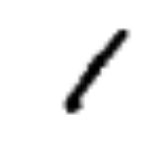

index1, label 0


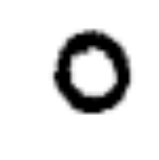

In [47]:
%matplotlib inline
#import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt


def show_image(img):
    plt.figure(figsize=(1.5, 1.5))
    plt.axis('off')
    if img.ndim == 3:
        img = img[0, :, :]
    plt.imshow(img, cmap=plt.cm.binary)           
    plt.show()

print('index0, label {}'.format(train_y[0]))
show_image(train_imgs[0])
print('index1, label {}'.format(train_y[1]))
show_image(train_imgs[1])
#show_image(train_imgs[2])
#show_image(train_imgs[3])

## Define CNN (Convolutional Neural Network)

Required package:
 - chainer >= 2.0

Convolutional neural network consists of convolution layer followed by fully connected layer.

In [48]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer.dataset.convert import concat_examples


class CNNMedium(chainer.Chain):
    def __init__(self, n_out):
        super(CNNMedium, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 16, 3, 1)
            self.conv2 = L.Convolution2D(16, 32, 3, 1)
            self.conv3 = L.Convolution2D(32, 32, 3, 1)
            self.conv4 = L.Convolution2D(32, 32, 3, 2)
            self.conv5 = L.Convolution2D(32, 64, 3, 1)
            self.conv6 = L.Convolution2D(64, 32, 3, 1)
            self.fc7 = L.Linear(None, 30)
            self.fc8 = L.Linear(30, n_out)

    def __call__(self, x):
        h = F.leaky_relu(self.conv1(x), slope=0.05)
        h = F.leaky_relu(self.conv2(h), slope=0.05)
        h = F.leaky_relu(self.conv3(h), slope=0.05)
        h = F.leaky_relu(self.conv4(h), slope=0.05)
        h = F.leaky_relu(self.conv5(h), slope=0.05)
        h = F.leaky_relu(self.conv6(h), slope=0.05)
        h = F.leaky_relu(self.fc7(h), slope=0.05)
        h = self.fc8(h)
        return h

    def _predict_batch(self, x_batch):
        with chainer.no_backprop_mode(), chainer.using_config('train', False):
            h = self.__call__(x_batch)
            return F.softmax(h)

    def predict_proba(self, x, batchsize=32, device=-1):
        if device >= 0:
            chainer.cuda.get_device_from_id(device).use()
            self.to_gpu()  # Copy the model to the GPU

        y_list = []
        for i in range(0, len(x), batchsize):
            x_batch = concat_examples(x[i:i + batchsize], device=device)
            y = self._predict_batch(x_batch)
            y_list.append(chainer.cuda.to_cpu(y.data))
        y_array = np.concatenate(y_list, axis=0)
        return y_array

    def predict(self, x, batchsize=32, device=-1):
        proba = self.predict_proba(x, batchsize=batchsize, device=device)
        return np.argmax(proba, axis=1)

## Training code -- step 1.

In [49]:
if DEBUG:
    print('DEBUG mode, reduce training data...')
    # Use only first 1000 example to reduce training time
    train_x = train_x[:1000]
    train_imgs = train_imgs[:1000]
    train_y = train_y[:1000]
else:
    print('No DEBUG mode')

No DEBUG mode


In [50]:
from chainer import iterators, training, optimizers, serializers
from chainer.datasets import TupleDataset
from chainer.training import extensions


# -1 indicates to use CPU, 
# positive value indicates GPU device id.
#device = -1  # If you use CPU.
device = 0  # If you use GPU. (You need to install chainer & cupy with CUDA/cudnn installed)
batchsize = 16
class_num = 10
out_dir = '.'
if DEBUG:
    epoch = 5  # This value is small. Change to more than 20 for Actual running.
else:
    epoch = 20


def train_main(train_x, train_y, val_x, val_y, model_path='cnn_model.npz'):
    # 1. Setup model    
    model = CNNMedium(n_out=class_num)
    classifier_model = L.Classifier(model)
    if device >= 0:
        chainer.cuda.get_device(device).use()  # Make a specified GPU current
        classifier_model.to_gpu()  # Copy the model to the GPU

    # 2. Setup an optimizer
    optimizer = optimizers.Adam()
    #optimizer = optimizers.MomentumSGD(lr=0.001)
    optimizer.setup(classifier_model)

    # 3. Load the dataset
    #train_data = MNISTTrainImageDataset()
    train_dataset = TupleDataset(train_x, train_y)
    val_dataset = TupleDataset(val_x, val_y)

    # 4. Setup an Iterator
    train_iter = iterators.SerialIterator(train_dataset, batchsize)
    #train_iter = iterators.MultiprocessIterator(train, args.batchsize, n_prefetch=10)
    val_iter = iterators.SerialIterator(val_dataset, batchsize, repeat=False, shuffle=False)
    
    # 5. Setup an Updater
    updater = training.StandardUpdater(train_iter, optimizer, 
                                       device=device)
    # 6. Setup a trainer (and extensions)
    trainer = training.Trainer(updater, (epoch, 'epoch'), out=out_dir)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(val_iter, classifier_model, device=device), trigger=(1, 'epoch'))

    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(1, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'validation/main/loss'],
        x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        x_key='epoch',
        file_name='accuracy.png'))

    try:
        # Use extension library, chaineripy's PrintReport & ProgressBar
        from chaineripy.extensions import PrintReport, ProgressBar
        trainer.extend(ProgressBar(update_interval=5))
        trainer.extend(PrintReport(
            ['epoch', 'main/loss', 'validation/main/loss',
             'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    except:
        print('chaineripy is not installed, run `pip install chaineripy` to show rich UI progressbar')
        # Use chainer's original ProgressBar & PrintReport
        # trainer.extend(extensions.ProgressBar(update_interval=5))
        trainer.extend(extensions.PrintReport(
            ['epoch', 'main/loss', 'validation/main/loss',
             'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    # Resume from a snapshot
    # serializers.load_npz(args.resume, trainer)

    # Run the training
    trainer.run()
    # Save the model
    serializers.save_npz('{}/{}'
                         .format(out_dir, model_path), model)
    return model

In [51]:
import numpy as np
from sklearn.model_selection import train_test_split
seed = 777
model_simple = 'cnn_model_simple.npz'

train_idx, val_idx = train_test_split(np.arange(len(train_x)),
                                      test_size=0.20, random_state=seed)
print('train size', len(train_idx), 'val size', len(val_idx))
train_main(train_imgs[train_idx], train_y[train_idx], train_imgs[val_idx], train_y[val_idx], model_path=model_simple)

train size 33600 val size 8400


## Predict the label and make submission file

Load trained model and create submit file.

In [52]:
class_num = 10

def predict_main(model_path='cnn_model.npz'):
    # 1. Setup model
    model = CNNMedium(n_out=class_num)
    classifier_model = L.Classifier(model)
    if device >= 0:
        chainer.cuda.get_device(device).use()  # Make a specified GPU current
        classifier_model.to_gpu()  # Copy the model to the GPU

    # load trained model
    serializers.load_npz(model_path, model)

    # 2. Prepare the dataset --> it's already prepared
    # test_imgs

    # 3. predict the result
    t = model.predict(test_imgs, device=device)
    return t
 

def create_submission(submission_path, t):
    result_dict = {
        'ImageId': np.arange(1, len(t) + 1),
        'Label': t
    }
    df = pd.DataFrame(result_dict)
    df.to_csv(submission_path,
              index_label=False, index=False)
    print('submission file saved to {}'.format(submission_path))

In [53]:
predict_label = predict_main(model_path=model_simple)
print('predict_label = ', predict_label, predict_label.shape)

create_submission('submission_simple.csv', predict_label)

predict_label =  [2 0 9 ..., 3 9 2] (28000,)
submission file saved to submission_simple.csv


## Submit file: score 0.96400

We have finished the basic course of Convolutional Neural Network training and prediction by traind CNN.
The above submission file scored 0.96400 in my environment.

How to further improve the score? Let's consider the advanced step below...

## Improve model performance

The simple model training is introduced above, 
but the accuracy is not enough.

We can further increase the model performance by considering

 - Data augmentation
 - model emsemble

From below, I will explain how to achieve data augmentation training with chainer, 
and train multiple models to emsemble its prediction to get final output.

## Data augmentation


To increase validation score, the number of training data is important.
When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data.
For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation
AffineTransformation
2. Translation
3. Scale
4. Shear

I show example below.

Affine transformation, image:  (28, 28)
Original image


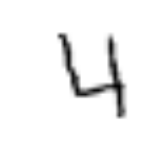

Transformed image


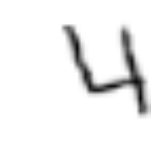

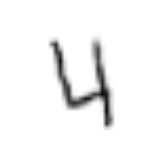

In [54]:
from chainer.datasets import TransformDataset
import skimage
import skimage.transform
from skimage.transform import AffineTransform, warp
import numpy as np

def affine_image(img):
    #ch, h, w = img.shape
    #img = img / 255.
    
    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)
    
    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.
    
    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.
    
    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, 
                            translation=(tx, ty))
    transformed_image = warp(img[0, :, :], tform.inverse, output_shape=(28, 28))
    return transformed_image

transformed_imgs = TransformDataset(train_imgs / 255., affine_image)

print('Affine transformation, image: ', transformed_imgs[0].shape)
#print(train_imgs[0])
print('Original image')
show_image(train_imgs[3])
print('Transformed image')
show_image(transformed_imgs[3])
show_image(transformed_imgs[3])

Does transformed image look like the same number with the original image (in this case 4)?

Yes, even when the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. 
We can virtually create another image data from one image in such a way.

### Define dataset class

Chainer provides a way to define your own dataset which can be customized.

We can define the class by extending `DatasetMixin` class.
Here, we can implement task-specific data augmentation code.

In [55]:
class MNISTTrainImageDataset(chainer.dataset.DatasetMixin):
    def __init__(self, imgs, labels, train=True, augmentation_rate=1.0,
                 min_scale=0.90, max_scale=1.10, max_rot_angle=4,
                 max_shear_angle=2, max_translation=3):
        self.imgs = imgs.reshape((-1, 1, 28, 28))
        self.labels = labels
        self.train = train

        # affine parameters
        self.augmentation_rate = augmentation_rate
        self.min_scale = min_scale  # 0.85
        self.max_scale = max_scale  # 1.15
        self.max_rot_angle = max_rot_angle  # 5
        self.max_shear_angle = max_shear_angle  # 5
        self.max_translation = max_translation

    def __len__(self):
        """return length of this dataset"""
        return len(self.labels)

    def affine_image(self, img):
        # ch, h, w = img.shape

        # --- scale ---
        sx = np.random.uniform(self.min_scale, self.max_scale)
        sy = np.random.uniform(self.min_scale, self.max_scale)

        # --- rotation ---
        rot_angle = np.random.uniform(-self.max_rot_angle,
                                      self.max_rot_angle) * np.pi / 180.

        # --- shear ---
        shear_angle = np.random.uniform(-self.max_shear_angle,
                                        self.max_shear_angle) * np.pi / 180.

        # --- translation ---
        tx = np.random.randint(-self.max_translation, self.max_translation)
        ty = np.random.randint(-self.max_translation, self.max_translation)

        tform = AffineTransform(scale=(sx, sy), rotation=rot_angle,
                                shear=shear_angle,
                                translation=(tx, ty))
        transformed_image = warp(img[0, :, :], tform.inverse,
                                 output_shape=(28, 28))
        return transformed_image.astype('float32').reshape(1, 28, 28)

    def get_example(self, i):
        """Return i-th data"""
        img = self.imgs[i]
        label = self.labels[i]

        # Data augmentation...
        if self.train:
            if np.random.uniform() < self.augmentation_rate:
                img = self.affine_image(img)

        return img, label

In [56]:
# 3. Load the dataset
train_data = MNISTTrainImageDataset(train_imgs, train_y)

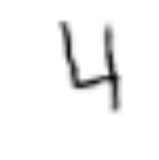

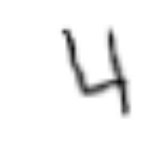

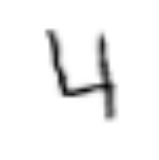

In [57]:
# train_data[i] is `i`-th dataset, with format (img, label)

# extract 3rd dataset
index = 3
img, label = train_data[index]

show_image(train_data[index][0])
show_image(train_data[index][0])
show_image(train_data[index][0])

What happed? I have used the same code, `show_image(train_data[index][0])` but the resulting image is different!!

When the customized dataset `MNISTTrainImageDataset` is defined,
`get_example(self, i)` is always called when we access the data by index (`train_data[index]`).

The result was different each time since we have randomly determine the scale, rotation, shear, translation parameter each time.

We can use `train_data` dataset for chainer's CNN model training, which automatically applies data augmentation for you:).

## Training code -- step 2.

Step 1, we tried a simple training script.
Let's train the model with 
 - data augmentation
 - cross validation


In [58]:
# -1 indicates to use CPU, 
# positive value indicates GPU device id.
# device = -1  # If you use CPU.
device = 0  # If you use GPU. (You need to install chainer & cupy with CUDA/cudnn installed)

batchsize = 16
class_num = 10
out_dir = '.'
if DEBUG:
    epoch = 5  # This value is small. Change to more than 20 for Actual running.
else:
    epoch = 30


def train_main2(train_x, train_y, val_x, val_y, model_path='cnn_model.npz', model_class=CNNMedium):
    # 1. Setup model
    model = model_class(n_out=class_num)
    classifier_model = L.Classifier(model)
    if device >= 0:
        chainer.cuda.get_device(device).use()  # Make a specified GPU current
        classifier_model.to_gpu()  # Copy the model to the GPU

    # 2. Setup an optimizer
    optimizer = optimizers.Adam()
    # optimizer = optimizers.MomentumSGD(lr=0.01)
    optimizer.setup(classifier_model)

    # 3. Load the dataset
    # --- Use custom dataset to train model with data augmentation ---
    train_dataset = MNISTTrainImageDataset(train_x, train_y, augmentation_rate=0.5,
                                           min_scale=0.95, max_scale=1.05, max_rot_angle=7,
                                           max_shear_angle=3, max_translation=2)
    val_dataset = MNISTTrainImageDataset(val_x, val_y, train=False)
    # --- end of modification ---

    # 4. Setup an Iterator
    train_iter = iterators.SerialIterator(train_dataset, batchsize)
    #train_iter = iterators.MultiprocessIterator(train, args.batchsize, n_prefetch=10)
    val_iter = iterators.SerialIterator(val_dataset, batchsize, repeat=False, shuffle=False)
    
    # 5. Setup an Updater
    updater = training.StandardUpdater(train_iter, optimizer, 
                                       device=device)
    # 6. Setup a trainer (and extensions)
    trainer = training.Trainer(updater, (epoch, 'epoch'), out=out_dir)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(val_iter, classifier_model, device=device), trigger=(1, 'epoch'))

    # --- Learning rate decay scheduling ---
    def decay_lr(trainer):
        print('decay_lr at epoch {}'.format(trainer.updater.epoch_detail))
        # optimizer.lr *= 0.1  # for MomentumSGD optimizer
        optimizer.alpha *= 0.1
        print('optimizer lr has changed to {}'.format(optimizer.lr))
    trainer.extend(decay_lr, 
                   trigger=chainer.training.triggers.ManualScheduleTrigger([10, 20], 'epoch'))
    # --- end of modification ---

    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(1, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'validation/main/loss'],
        x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        x_key='epoch',
        file_name='accuracy.png'))

    try:
        # Use extension library, chaineripy's PrintReport & ProgressBar
        from chaineripy.extensions import PrintReport, ProgressBar
        trainer.extend(ProgressBar(update_interval=5))
        trainer.extend(PrintReport(
            ['epoch', 'main/loss', 'validation/main/loss',
             'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    except:
        print('chaineripy is not installed, run `pip install chaineripy` to show rich UI progressbar')
        # Use chainer's original ProgressBar & PrintReport
        # trainer.extend(extensions.ProgressBar(update_interval=5))
        trainer.extend(extensions.PrintReport(
            ['epoch', 'main/loss', 'validation/main/loss',
             'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    # Resume from a snapshot
    # serializers.load_npz(args.resume, trainer)

    # Run the training
    trainer.run()
    # Save the model
    serializers.save_npz('{}/{}'.format(out_dir, model_path), model)
                         
    return model

### Train the model with cross validation

Sklearn provides simple API to execute cross validation. The code 

`for train_idx, valid_idx in StratifiedKFold(n_splits=N_SPLIT_CV).split(train_imgs, train_y):`

is used to apply cross validation. 
`StratifiedKFold` automatically keeps the balance of each label in train and validation split.

Let's run below code to train the model with cross validation.

Note that each training takes longer time to converge to get the minimum train loss value.

This is because the input data is augmented and the model will get different image in each epoch.

In [59]:
from sklearn.model_selection import KFold, StratifiedKFold

if DEBUG:
    N_SPLIT_CV = 2
else:
    N_SPLIT_CV = 5

cv_step = 0
# for train_idx, valid_idx in StratifiedKFold(n_splits=N_SPLIT_CV, shuffle=True, random_state=7).split(train_imgs, train_y):
for train_idx, valid_idx in StratifiedKFold(n_splits=N_SPLIT_CV).split(train_imgs, train_y):
    print('Training cv={} ...'.format(cv_step))
    train_main2(train_imgs[train_idx], train_y[train_idx], 
                train_imgs[val_idx], train_y[val_idx], 
                model_path='cnn_model_cv{}.npz'.format(cv_step))
    cv_step += 1

Training cv=0 ...
decay_lr at epoch 10.000059532668551
optimizer lr has changed to 9.99999999623707e-05
decay_lr at epoch 20.000119065337103
optimizer lr has changed to 1e-05
Training cv=1 ...
decay_lr at epoch 10.00041670387237
optimizer lr has changed to 9.999999996244591e-05
decay_lr at epoch 20.000357174747744
optimizer lr has changed to 1e-05
Training cv=2 ...
decay_lr at epoch 10.000178566114103
optimizer lr has changed to 9.999999996252098e-05
decay_lr at epoch 20.000357132228206
optimizer lr has changed to 1e-05
Training cv=3 ...
decay_lr at epoch 10.000059518495373
optimizer lr has changed to 9.999999996255845e-05
decay_lr at epoch 20.000119036990746
optimizer lr has changed to 1e-05
Training cv=4 ...
decay_lr at epoch 10.000238066896799
optimizer lr has changed to 9.99999999625959e-05
decay_lr at epoch 20.0
optimizer lr has changed to 1e-05


## Predict with model emsemble



In [60]:
class_num = 10

device= 1
def predict_proba_main(model_path='cnn_model.npz'):
    # 1. Setup model
    model = CNNMedium(n_out=class_num)
    classifier_model = L.Classifier(model)
    if device >= 0:
        chainer.cuda.get_device(device).use()  # Make a specified GPU current
        classifier_model.to_gpu()  # Copy the model to the GPU

    # load trained model
    serializers.load_npz(model_path, model)

    # 2. Load the dataset
    # test_imgs is already prepared

    # 3. predict the result
    proba = model.predict_proba(test_imgs, device=device)
    return proba


def create_submission(submission_path, t):
    result_dict = {
        'ImageId': np.arange(1, len(t) + 1),
        'Label': t
    }
    df = pd.DataFrame(result_dict)
    df.to_csv(submission_path,
              index_label=False, index=False)
    print('submission file saved to {}'.format(submission_path))

In [61]:
proba_list = []
for i in range(N_SPLIT_CV):
    print('predicting {}-th model...'.format(i))
    proba = predict_proba_main(model_path='./cnn_model_cv{}.npz'.format(i))
    proba_list.append(proba)
  
proba_array = np.array(proba_list)

predicting 0-th model...
predicting 1-th model...
predicting 2-th model...
predicting 3-th model...
predicting 4-th model...


Take each model's probability mean as final ensemble prediction

In [62]:
proba_ensemble = np.mean(proba_array, axis=0)  # Take each model's mean as ensembled prediction.
predict_ensemble = np.argmax(proba_ensemble, axis=1)

# --- Check shape ---
# 0th axis represents each model, 1st axis represents test data index, 2nd axis represents the probability of each label
print('proba_array', proba_array.shape)
# 0th axis represents test data index, 1st axis represents the probability of each label
print('proba_ensemble', proba_ensemble.shape)
# 0th axis represents final label prediction for test data index
print('predict_ensemble', predict_ensemble.shape, predict_ensemble)

proba_array (5, 28000, 10)
proba_ensemble (28000, 10)
predict_ensemble (28000,) [2 0 9 ..., 3 9 2]


In [63]:
create_submission('submission_ensemble.csv', predict_ensemble)

submission file saved to submission_ensemble.csv


### Submit file: score 0.99700¶

That is the end of intermidiate course of Convolutional Neural Network training and prediction by traind CNN.

I have introduced major technics used in deep learning field to increase the accuracy such as, 
 - data augmentation
 - cross validation
 - model ensemble
 - learning rate scheduling for CNN training

After these effort, the above submission file scored 0.99700 in my environment :)


## Appendix

### Visualize data with high loss error

Some may ask can we achieve 100 % accuracy for this digit-recognizer task?

To understand how difficult is to increase the accuracy, let's see the "most difficult data" 
for the trained model to predict.

The codes below calculates the softmax cross entropy loss for each image data, and shows most highest loss images.

In [81]:
from chainer import cuda

def calc_loss_and_prob(model_path='cnn_model.npz'):
    # 1. Setup model
    model = CNNMedium(n_out=class_num)
    classifier_model = L.Classifier(model)
    if device >= 0:
        chainer.cuda.get_device(device).use()  # Make a specified GPU current
        classifier_model.to_gpu()  # Copy the model to the GPU

    # load trained model
    serializers.load_npz(model_path, model)

    # 2. Load the dataset
    # test_imgs is already prepared

    # 3. predict the result
    if device >= 0:
        h = model(cuda.to_gpu(train_imgs))
        loss = F.softmax_cross_entropy(h, cuda.to_gpu(train_y), reduce='no')
        return cuda.to_cpu(loss.data), cuda.to_cpu(h.data)
    else:
        h = model(train_imgs)
        loss = F.softmax_cross_entropy(h, train_y)
        return loss.data, h.data

In [82]:
loss_list = []
prob_list = []
for i in range(N_SPLIT_CV):
    print('calc loss for {}-th model...'.format(i))
    loss, prob = calc_loss_and_prob(model_path='./cnn_model_cv{}.npz'.format(i))
    loss_list.append(loss)
    prob_list.append(prob)
  
loss_array = np.array(loss_list)
prob_array = np.array(prob_list)

calc loss for 0-th model...
calc loss for 1-th model...
calc loss for 2-th model...
calc loss for 3-th model...
calc loss for 4-th model...


In [87]:
loss_ensemble = np.mean(loss_array, axis=0)  # Take each model's mean loss.
predict_ensemble = np.mean(prob_array, axis=0)  # Take each model's mean as ensembled prediction.

# --- Check shape ---
# 0th axis represents each model, 1st axis represents test data index, 2nd axis represents the probability of each label
print('loss_array', loss_array.shape)
# 0th axis represents test data index, 1st axis represents the probability of each label
print('loss_ensemble', loss_ensemble.shape)

loss_array (5, 42000)
loss_ensemble (42000,)


In [88]:
loss_index = np.argsort(loss_ensemble)
print('BEST100:  ', loss_index[:30], loss_ensemble[loss_index[:30]])
print('WORST100: ', loss_index[::-1][:100], loss_ensemble[loss_index[::-1][:100]])

BEST100:   [20999 26868 12769 12768 12767 26871 12765 12771 26872 26876 12761 12760
 26877 12758 12757 26874 26865 12773 26864 12789 26843 26846 26849 26852
 26853 26854 26855 26857 12780 12779] [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
WORST100:  [16301 37013 36018 24477 15065 25946 36984 14434 21021 12520 23299 35063
 29524  4226 18283 25172 29296 36569 29436  3997 26182   125 36916 25073
 22089 25468 36755 18502 13044 30119  7369 25069 25708 25074 18534 14032
 41691 28560 25619 23135 30275 12706 15219  2381  4967 18316 29496 27489
 12170 34274  2316 18319 12560  7389 14101 17016  8780 23604 23036  5885
 10941  5747  7764 24109 22368 27977  7242  2453 24153 10644 15281 29033
 13477 20172 39331 14121  7505  4169 11406  5124  8566 24230  5659 27335
  6781  5294 15121 13920 24891  7725 26661 30317 28439 23538   897 40257
 30548  4047 18909 19234] [ 8.8119154   5.83190393  5.60041142  4.66397429  2.71987653 

In [89]:
def show_images(imgs):
    num_imgs = len(imgs)
    fig, axs = plt.subplots(nrows=1, ncols=num_imgs)
    # plt.figure(figsize=(1.5, 1.5))
    plt.axis('off')
    #if img.ndim == 3:
    #    img = img[0, :, :]
    print('imgs shape', imgs.shape)
    for i in range(num_imgs):
        axs[i].imshow(imgs[i, 0, :, :], cmap=plt.cm.binary)           
        axs[i].axis('off')
    plt.show()

label  [4 4 3 3 9 7 8 4 1 9]
predict  [7 9 9 5 4 1 8 9 1 9]
imgs shape (10, 1, 28, 28)


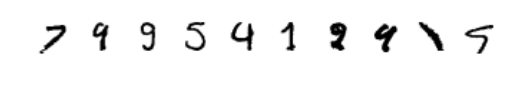

In [91]:
worst_index = loss_index[::-1][:10]
print('label ', train_y[worst_index])
print('predict ', np.argmax(predict_ensemble, axis=1)[worst_index])
show_images(train_imgs[worst_index])

#for i in loss_index[::-1][:10]:
#    print('label ', train_y[i])
#    show_images(train_imgs[])

What do you think of these images & labels (answer)?

The first image really looks like 7 (and CNN model predict it as 7), but the label is 4.
This is most probably the case that "labelling is wrong", and the trained CNN model answer is quite reasonable.

These confusing data is included in the dataset and that is why it is difficult or impossible to achieve 100 % accuracy.